In [1]:
!pip install ..
!pip install datasets
!pip install pycocotools
!pip install bitsandbytes

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Processing /home/jovyan/rashkov/ru-dolph
  Preparing metadata (setup.py) ... done
  Created wheel for rudolph: filename=rudolph-0.0.1rc10-py3-none-any.whl size=40293 sha256=e4d46d6ff8e8c8243c05f4281cd7e3681c40b9fdfd82de748e7754f02a3d068c
  Stored in directory: /tmp/pip-ephem-wheel-cache-l29oja68/wheels/2b/3d/dc/a117001cc39aba083598dd3532c4e0ff93732272b507afb95e
Successfully built rudolph
  Attempting uninstall: rudolph
    Found existing installation: rudolph 0.0.1rc10
    Uninstalling rudolph-0.0.1rc10:
      Successfully uninstalled rudolph-0.0.1rc10
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch
from rudalle import get_vae
from rudalle.utils import seed_everything

import sys
sys.path.insert(0, 'ru-dolph')

import os
from glob import glob
from os.path import join
from datetime import datetime

import torch
import bitsandbytes as bnb
from torch.utils.data import Dataset, DataLoader
import torchvision
import transformers
import more_itertools
import numpy as np
import pandas as pd
import random
import json
from PIL import Image, ImageDraw
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm.auto import tqdm
from einops import rearrange
import youtokentome as yttm

import torchvision
from rudalle.image_prompts import ImagePrompts
from rudolph.model import get_rudolph_model, ruDolphModel, FP16Module
from rudolph import utils
from rudolph.model.utils import get_attention_mask
from rudalle import get_tokenizer, get_vae
from rudolph.api import ruDolphApi

import datasets
import random
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from PIL import Image
import pickle

from typing import Any, Callable, Optional, Tuple, List


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


In [3]:
device = 'cuda'

In [4]:
torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [6]:
seed_everything(42)

In [7]:
model = get_rudolph_model('1.3B', pretrained=True, fp16=True, device='cuda')

NEW VERSION!!!!!!


/home/jovyan/.imgenv-rudolph-obj-detection2-0/lib/python3.7/site-packages/huggingface_hub/file_download.py:632: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


In [8]:
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


In [74]:
class Args():
    def __init__(self, model, checkpoint_path):
        self.device = model.get_param('device')
        self.l_text_seq_length = model.get_param('l_text_seq_length')
        self.r_text_seq_length = model.get_param('r_text_seq_length')
        self.image_tokens_per_dim = model.get_param('image_tokens_per_dim')
        self.image_seq_length = model.get_param('image_seq_length')
        self.epochs = 1
        self.save_path= checkpoint_path
        self.model_name = 'rudolph_object_detection_grounding_neg_sampling_coco_vg_'
        self.save_every = 10000
        self.bs = 1
        self.clip = 1.0
        self.lr = 2e-5
        self.wandb = False
        self.lt_loss_weight = 0.01
        self.img_loss_weight = 0.01
        self.rt_loss_weight = 7
        self.loc_loss_weight = 0.05
        self.category_weight = 0
        self.bin_size = 8
        self.ob_seq_len = 5
        self.conf_loss_weight=0
        self.conf_grad=5
        self.cat_idx=4
        self.conf_idx=None
        self.loc_len=4
        self.prob_threshold = 0.15
        self.image_size = self.image_tokens_per_dim * self.bin_size
        
checkpoint_path = '../model/checkpoints/'
args = Args(model, checkpoint_path)
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

In [10]:
SPC_TOKENS = {
    '<LT_UNK>': 16384,
    '<RT_UNK>': 16385,
    '<LT_T2I>': 16386,
    '<LT_I2T>': 16387,
    '<LT_T2T>': 16388,
    '<RT_I2T>': 16389,
    
    '<LT_TQA>': 16390,
    '<RT_TQA>': 16391,
    '<LT_ODG>': 16392,
    '<RT_ODG>': 16393,
}

In [11]:
for n in range(args.image_tokens_per_dim):
    n_token = SPC_TOKENS['<RT_ODG>']+1+n
    SPC_TOKENS['<RT_OD'+str(n)+'>'] = n_token
last_spc_token = n_token

SPC_TOKENS['<RT_NB>']= last_spc_token+1
SPC_TOKENS['<RT_NL>']= last_spc_token+2

In [12]:
image_transform = T.Compose([
    T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
    T.ToTensor(),
    T.Resize((args.image_size, args.image_size))
    ])

In [13]:
exclude_val_list = np.load('../../data/coco_val_exclude.npy')

In [14]:
class CocoVisualGenomeDataset(Dataset):
    spc_id = -1

    def __init__(
        self,
        tokenizer,
        rus_categories_list,
        coco_exclude_list,
        coco_root: str,
        coco_ann_file: str,
        vg_annotation_path: str,
        vg_images_root: str,
        args,
        add_left_special_token,
        coco_len = None,
        coco_vg_balance:float=100,
        image_transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__()
        
        self.coco_root = coco_root
        
        self.args = args
        
        self.image_size = args.image_size
        self.bin_size = args.bin_size
        self.r_text_seq_length = args.r_text_seq_length
        self.l_text_seq_length = args.l_text_seq_length
        self.image_tokens_per_dim = args.image_tokens_per_dim
        
        self.add_left_special_token = add_left_special_token
        
        self.image_transform = image_transform
        
        self.tokenizer = tokenizer
        self.tokenizer_eos_id = tokenizer.eos_id
        self.tokenizer_bos_id = tokenizer.bos_id
        self.spc_tokens = SPC_TOKENS
        
        self.data = []
        
        text_prompt = 'найди на картинке все '

        self.coco = COCO(coco_ann_file)
        self.idxs = list(sorted(self.coco.imgs.keys()))
        for ex_img in coco_exclude_list:
            self.idxs.remove(ex_img)
         
        
        categories = self.coco.dataset['categories']
        cat_idxs = list([cat['id'] for cat in categories])
        self.category_encoding_map = {}
        for i, cat in enumerate(categories):
            self.category_encoding_map[cat['id']] = self.encode_text(text=text_prompt+rus_categories_list[i],
                                                                text_seq_length=args.l_text_seq_length,
                                                                     add_special = add_left_special_token)
        
        
        coco_counter = 0
        for idx in self.idxs:
            anns = self.coco.loadAnns(self.coco.getAnnIds(idx))
            anns_df = pd.DataFrame(anns)
            if len(anns_df.columns)>0:
                cat_id_set = set(anns_df['category_id'])
                for cat_id in cat_id_set:
                    coco_image = self.coco.loadImgs(idx)[0]["file_name"]
                    new_sample = {'encoded_left':self.category_encoding_map[cat_id],
                                 'bboxes':anns_df[anns_df['category_id']==cat_id]['bbox'].tolist(),
                                'image_address':os.path.join(self.coco_root, coco_image)}
                    self.data.append(new_sample)
                    coco_counter += 1
            if coco_len is not None and coco_counter>coco_len:
                break
        
        self.vg_images_root = vg_images_root
        with open(vg_annotation_path, 'rb') as fj:
            vg_annotation = json.load(fj)
        
        vg_counter = 0
        for image_name in vg_annotation.keys():
            if vg_counter < coco_counter * coco_vg_balance:
                if image_name in os.listdir(self.vg_images_root):
                    ann_img = vg_annotation[image_name]
                    for phrase in ann_img.keys():
                        new_sample = {'encoded_left':self.encode_text(text=text_prompt+phrase,
                                                                    text_seq_length=args.l_text_seq_length,
                                                                     add_special = add_left_special_token),
                                     'bboxes':[ann_img[phrase][0]],
                                    'image_address':os.path.join(self.vg_images_root, image_name)}
                        self.data.append(new_sample)
                        vg_counter += 1
            
    def _load_image(self, image_address) -> Image.Image:
        return Image.open(image_address)
    
    def resize_bbox(self, bbox, img_size):
        
        bbox_x0 = bbox[0]
        bbox_y0 = bbox[1]
        bbox_x1 = bbox_x0+bbox[2]
        bbox_y1 = bbox_y0+bbox[3]
        
        img_w = img_size[0]
        img_h = img_size[1]
        
        max_wh = max(img_w,img_h)

        resized_x0 = int(bbox_x0*self.image_size/img_w)
        resized_y0 = int(bbox_y0*self.image_size/img_h)
        resized_x1 = int(bbox_x1*self.image_size/img_w)
        resized_y1 = int(bbox_y1*self.image_size/img_h)
        return [resized_x0,resized_y0,resized_x1, resized_y1]
    
    def encode_bbox(self, resized_bbox):
        
        bbox_x0_bin = resized_bbox[0]//self.bin_size
        bbox_y0_bin = resized_bbox[1]//self.bin_size
        bbox_x1_bin = min(resized_bbox[2]//self.bin_size, self.image_tokens_per_dim-1)
        bbox_y1_bin = min(resized_bbox[3]//self.bin_size, self.image_tokens_per_dim-1)
        
        new_bbox_tokens = [SPC_TOKENS['<RT_OD'+str(bbox_x0_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_y0_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_x1_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_y1_bin)+'>']]
        
        return new_bbox_tokens
    
    def create_new_box(self):
        bbox_x0_bin = random.randint(0, self.args.image_tokens_per_dim-3)
        bbox_y0_bin = random.randint(0, self.args.image_tokens_per_dim-3)
        bbox_x1_bin = random.randint(bbox_x0_bin, self.args.image_tokens_per_dim-1)
        bbox_y1_bin = random.randint(bbox_y0_bin, self.args.image_tokens_per_dim-1)
        new_bbox_tokens = [SPC_TOKENS['<RT_OD'+str(bbox_x0_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_y0_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_x1_bin)+'>'],
                           SPC_TOKENS['<RT_OD'+str(bbox_y1_bin)+'>'],
                           SPC_TOKENS['<RT_NL>']
                          ]
        return new_bbox_tokens
    
    def encode_target(self, bboxes, img_size):
        encoded_target = [self.tokenizer_bos_id, SPC_TOKENS['<RT_ODG>']]
        ground_truth = []
        
        for i,bbox in enumerate(bboxes):
            
            resized_bbox = self.resize_bbox(bbox, img_size)
            encoded_bbox = self.encode_bbox(resized_bbox)
            
            ground_truth += resized_bbox
            ground_truth += [0]
            
            for loc_token in encoded_bbox:
                encoded_target.append(loc_token)
            encoded_target.append(SPC_TOKENS['<RT_NB>'])
        for k in range((self.r_text_seq_length-2-len(encoded_target))//5+1):
            encoded_target += self.create_new_box()
            
        encoded_target.append(SPC_TOKENS['<RT_NL>'])
        
        return torch.Tensor(encoded_target), torch.Tensor(ground_truth)
    
    def encode_text(self, text, text_seq_length, add_special = True):
        tokens = self.tokenizer.tokenizer.encode([text], output_type=yttm.OutputType.ID)[0]
        bos = [self.tokenizer.bos_id]
        if add_special:
            bos.append(self.spc_id)
        tokens = bos + tokens + [self.tokenizer.eos_id]
        return self.tokenizer.prepare_tokens(tokens, text_seq_length)
        
    def __getitem__(self, index):
        
        sample = self.data[index]
        left_encoded_text = sample['encoded_left']
        bboxes = sample['bboxes']
        image_address = sample['image_address']
        
        image = self._load_image(image_address)
        img_size = image.size
        transformed_image = self.image_transform(image)
        
        left_special_token = '<LT_ODG>'
        right_special_token = '<RT_ODG>'
        
        left_encoded_text[torch.where(left_encoded_text == self.spc_id)] = self.spc_tokens[left_special_token]
        
        encoded_target, ground_truth = self.encode_target(bboxes, img_size)

        return left_encoded_text, transformed_image, encoded_target, ground_truth
    
    def __len__(self):
        return len(self.data)

In [15]:
cat_rus_names = ["человек","велосипед","автомобиль","мотоцикл","самолёт","автобус","поезд","грузовик","лодка",
                 "светофор","гидрант","знак стоп","парковочный счетчик","скамейка","птица","кошка","собака",
                "лошадь","овца","корова","слон","медведь","зебра","жираф","рюкзак","зонт","сумочка","галстук",
                "чемодан","фрисби","лыжи","сноуборд","спортивный мяч","воздушный змей","бейсбольная бита",
                 "бейсбольная перчатка","скейтборд","доска для сёрфинга","теннисная ракетка","бутылка","бокал для вина",
                 "чашка","вилка","нож","ложка","миска","банан","яблоко","сэндвич","апельсин","брокколи","морковь",
                 "ход-дог","пицца","пончик","торт","стул","диван","растение в горшке","кровать","обеденный стол","туалет","телевизор",
                 "ноутбук","компьютерная мышь","пульт","клавиатура","мобильный телефон","микроволновка","духовка",
                 "тостер","раковина","холодильник","книга","часы","ваза","ножницы","плюшевый мишка","фен","зубная щётка"]

In [16]:
val_dataset = CocoVisualGenomeDataset(coco_root=r'../../data/val2017',
                             coco_ann_file=r'../../data/annotations/instances_val2017.json',
                                      coco_len = 3000,
                                coco_vg_balance=5000/30000,
                             image_transform=image_transform,
                             tokenizer=tokenizer,
                             args = args,
                             coco_exclude_list=exclude_val_list,
                             rus_categories_list=cat_rus_names,
                                      vg_annotation_path=r'../../data/vg_intersection_rus_val_4.json',
                                      vg_images_root = r'../../data/VG_100K_2',
                                      add_left_special_token = True
                            )

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


In [17]:
def decode_text(tokenizer, encoded, ignore_ids):
    return tokenizer.tokenizer.decode(encoded.cpu().numpy().tolist(), ignore_ids=ignore_ids)[0]

In [18]:
ignore_ids = [
    tokenizer.eos_id, tokenizer.bos_id, tokenizer.unk_id, tokenizer.pad_id,
    -1, *list(SPC_TOKENS.values())
]

In [58]:
model.load_state_dict(torch.load('../model/checkpoints/rudolph_object_detection_grounding_neg_sampling_coco_vg_nmsn_rudolph_300000.pt'))

In [20]:
def loc_to_coords(token:int) -> float:
    num_token = token - SPC_TOKENS['<RT_OD0>']
    return args.bin_size*num_token

def calc_area(bbox):
    w = bbox[2]-bbox[0]
    h = bbox[3]-bbox[1]
    return w*h

def tokens_to_bbox(tokens):
    bbox = torch.zeros(1,4)
    bbox[0,0] = loc_to_coords(tokens[0])
    bbox[0,1] = loc_to_coords(tokens[1])
    bbox[0,2] = loc_to_coords(tokens[2])
    bbox[0,3] = loc_to_coords(tokens[3])
    return bbox

def tokens_iou(pred_tokens, ground_truth_bbox):
    pred_bbox = tokens_to_bbox(pred_tokens)
    print(pred_bbox,ground_truth_bbox)
    iou = ops.box_iou(ground_truth_bbox, pred_bbox)
    return iou

In [27]:
class ruDolphPhraseGroundingApi(ruDolphApi):
    def __init__(self, model, tokenizer, vae, spc_tokens=None, quite=False, *, bs=24, q=0.5, txt_top_k=64,
                 img_top_k=768, txt_top_p=0.8, img_top_p=0.99, txt_temperature=0.9, img_temperature=1.0):
        
        super().__init__(model = model, tokenizer = tokenizer, vae = vae, spc_tokens = spc_tokens, quite = quite, bs = bs, q = q, txt_top_k = txt_top_k,
                 img_top_k = img_top_k, txt_top_p = txt_top_p, img_top_p = img_top_p, txt_temperature = txt_temperature, img_temperature = img_temperature)
    
    def generate_text_answers(self, image_tokens, left_text, vocab_size, top_k, top_p, temperature=1.0,
                              use_cache=True, template='', allowed_token_ids=None, special_token='',obj_det_seq_len=5):
        '''
            Generate right text tokens.
        '''
        self.model.eval()
        torch.cuda.empty_cache()
        generated_tokens = []
        chunk_bs = left_text.shape[0]
        
        template = template.lower().strip()
        template_encoded = self.encode_text(template, text_seq_length=self.r_text_seq_length)
        
        template_size = (template_encoded != 0).sum() - 1  # eos
        
        template_encoded = template_encoded[:template_size]
        template_encoded[torch.where(template_encoded == self.spc_id)] = self.spc_tokens[special_token]

        with torch.no_grad():
            attention_mask = self.get_attention_mask(chunk_bs)

            out = torch.cat((
                left_text.to(self.device),
                image_tokens,
                template_encoded.repeat(chunk_bs, 1).to(self.device),
            ), dim=1)

            cache = None
            iter_range = range(
                self.l_text_seq_length + self.image_seq_length + template_size, 
                self.l_text_seq_length + self.image_seq_length + self.r_text_seq_length
            )
            iter_start = self.l_text_seq_length + self.image_seq_length + template_size-1
            
            if not self.quite:
                iter_range = tqdm(iter_range)
                
            scores = torch.zeros(self.r_text_seq_length-template_size)
                
            for it in iter_range:  
                logits, cache = self.model(out, attention_mask, cache=cache, use_cache=use_cache, return_loss=False)
                
                logits = logits[:, -1, :self.vocab_size]
            
                if allowed_token_ids:
                    logits = logits[:, allowed_token_ids]
            
                logits /= temperature
                filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
                
                sample = torch.multinomial(probs, 1)
                if allowed_token_ids:
                        sample = torch.tensor(allowed_token_ids).to(self.device)[sample]
                
                scores[it-iter_start-1] = torch.max(probs, dim=1)[0]
            
                indexes = torch.where(sample >= self.vocab_size - self.l_text_seq_length)
                sample[indexes] = 3
                out = torch.cat((out, sample), dim=-1)

            generated_tokens.append(out[:, -self.r_text_seq_length:])

        tokens = torch.cat(generated_tokens)[:,:]

        return tokens, scores

In [39]:
def decode_right(right_tokens, length=None, scores=True, obj_det_seq_len=5, cat_idx=4):
    boxes = torch.zeros((length, 4))
    labels = torch.ones(length)
    scores = torch.zeros(length)
    
    real_length = len(right_tokens)//obj_det_seq_len
    
    for k in range(real_length):
        boxes[k,:] = right_tokens[k*obj_det_seq_len:obj_det_seq_len*k+cat_idx].unsqueeze(0).cpu()
        scores[k] = 1
        labels[k] = 0
        
    boxes[:real_length] -= SPC_TOKENS['<RT_OD0>']*torch.ones((real_length, 4))
    boxes *= args.bin_size

    return [{'boxes':boxes, 'labels':labels, 'scores':scores}]

In [107]:
def decode_right_prob(right_tokens, probs, prob_threshold=0, obj_det_seq_len=5, length=None, cat_idx=4, scores=True,
                      min_samples=0):
    bboxes = []
    boxes = torch.empty(0,4)

    real_length = len(right_tokens)//obj_det_seq_len
    
    # тупо сделать сортировку
    for k in range(real_length):
        prob = probs[k*obj_det_seq_len]*probs[k*obj_det_seq_len+1]*probs[k*obj_det_seq_len+2]*probs[k*obj_det_seq_len+3]*probs[k*obj_det_seq_len+4]
        if prob>prob_threshold:
            bboxes.append(right_tokens[k*obj_det_seq_len:k*obj_det_seq_len+cat_idx].unsqueeze(0).cpu().float())
            
    if len(bboxes)>0:
        boxes = torch.vstack(bboxes)
        
    if length is not None and len(boxes)<length:
        boxes = torch.vstack([boxes, torch.zeros(length-len(boxes),4)])
    labels = torch.ones(boxes.size(0))
    scores = torch.zeros(boxes.size(0))
    labels[:len(bboxes)] = torch.zeros(len(bboxes))  
    scores[:len(bboxes)] = torch.ones(len(bboxes))
        
    boxes[:len(bboxes)] -= SPC_TOKENS['<RT_OD0>']*torch.ones((len(bboxes), 4)).float()
    boxes *= args.bin_size

    return [{'boxes':boxes, 'labels':labels, 'scores':scores}]

In [24]:
def add_empty_samples(res, new_length):
    res_size = res['boxes'].size(0)
    
    boxes = torch.zeros((new_length, 4))
    labels = (SPC_TOKENS['<RT_NL>']-SPC_TOKENS['<RT_NB>'])*torch.ones(new_length)
    scores = torch.zeros(new_length)
    
    boxes[:res_size,:] = res['boxes']
    labels[:res_size] = res['labels']
    scores[:res_size] = res['scores']
    
    return [{'boxes':boxes, 'labels':labels, 'scores':scores}]

In [48]:
def decode_ground_truth(ground_truth, length=None, scores=True, obj_det_seq_len=5, cat_idx=4):
    boxes = torch.zeros((length, 4))
    labels = (SPC_TOKENS['<RT_NL>']-SPC_TOKENS['<RT_NB>'])*torch.ones(length)
    scores = torch.zeros(length)

    for k in range(len(ground_truth)//obj_det_seq_len):
        labels[k] = ground_truth[k*obj_det_seq_len+cat_idx].unsqueeze(0).cpu()
        boxes[k,:] = ground_truth[k*obj_det_seq_len:obj_det_seq_len*k+cat_idx].unsqueeze(0).cpu()
        scores[k] = 1

    return [{'boxes':boxes, 'labels':labels, 'scores':scores}]

# пример детекции на валидационном сете

In [43]:
api = ruDolphPhraseGroundingApi(model, tokenizer, vae, spc_tokens=SPC_TOKENS)
allowed_token_ids = list(SPC_TOKENS.values())+[0,3]

найди на картинке все мотоцикл


  0%|          | 0/126 [00:00<?, ?it/s]

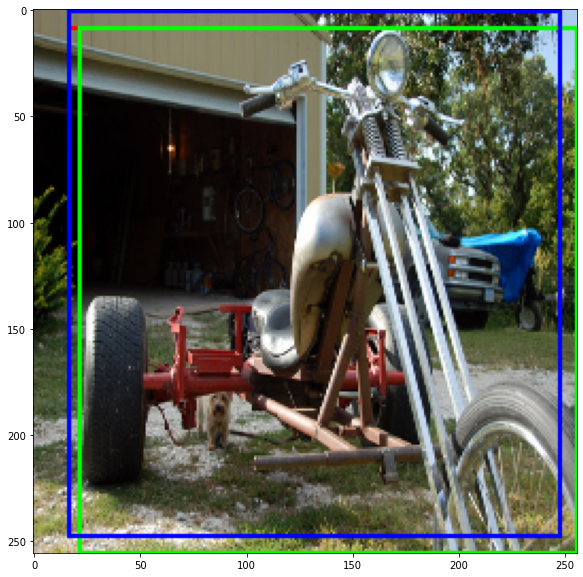

In [143]:
n=200

encoded_left_text, images, encoded_right_text, ground_truth = val_dataset.__getitem__(n)

text_prompt = 'найди на картинке все '

encoded_left_text = encoded_left_text.unsqueeze(0)
images = images.unsqueeze(0)
encoded_right_text = encoded_right_text.unsqueeze(0)

print(decode_text(tokenizer, encoded_left_text, ignore_ids))
    
bs_text = encoded_left_text.shape[0]

images = images.to(device)

image_seq_length = args.image_tokens_per_dim ** 2
total_seq_length = args.l_text_seq_length + image_seq_length + args.r_text_seq_length
encoded_images = vae.get_codebook_indices(images, disable_gumbel_softmax=True)

## Генерируем правые текстовые токены
pred_tokens, probs = api.generate_text_answers(encoded_images, encoded_left_text.type(torch.LongTensor), api.vocab_size, 
                            top_k=32, top_p=0.8, temperature=1.0, template = '', 
                            allowed_token_ids =allowed_token_ids, special_token='<RT_ODG>')

fake_cat_token = SPC_TOKENS['<RT_NL>']

target_fake_cat_token_idxs = torch.where(encoded_right_text[0,:]==fake_cat_token)[0]
if len(target_fake_cat_token_idxs)>0:
    target_end_idx = min(target_fake_cat_token_idxs)-4
else:
    target_end_idx=args.r_text_seq_length

if len(torch.where(pred_tokens[0,:]==fake_cat_token)[0])>0:
    pred_end_idx = min(torch.where(pred_tokens[0,:]==fake_cat_token)[0].cpu().numpy())-4
else:
    pred_end_idx=args.r_text_seq_length
    
    
target_len = (target_end_idx-2)//args.ob_seq_len
pred_len = (pred_end_idx-2)//args.ob_seq_len
gt_len =len(ground_truth)//args.ob_seq_len

gt = decode_ground_truth(ground_truth, length=gt_len, scores=False, obj_det_seq_len=args.ob_seq_len, cat_idx=args.cat_idx)
pred =  decode_right_prob(pred_tokens[0,2:pred_end_idx], probs=probs, prob_threshold=args.prob_threshold,
                           obj_det_seq_len=args.ob_seq_len, length=None, min_samples=1)

target = decode_right(encoded_right_text[0,2:target_end_idx], length=target_len)

img = images.squeeze(0).cpu()

img *= 255
img = img.to(torch.uint8)

real_len = len(torch.where(target[0]['labels']!=1)[0])

colors = [(255,0,0)]*real_len 
img_with_bboxes = draw_bounding_boxes(
    img, boxes=target[0]["boxes"][:real_len],colors=colors, width=2)

colors = [(0,255,0)]*gt_len 
img_with_bboxes = draw_bounding_boxes(
    img_with_bboxes, boxes=gt[0]["boxes"][:gt_len],colors=colors, width=2)

pred_len = len(torch.where(pred[0]['labels']!=1)[0])
pred_colors = [(0,0,255)]*pred_len 
img_with_bboxes = draw_bounding_boxes(
    img_with_bboxes, boxes=pred[0]["boxes"][:pred_len],colors=pred_colors, width=2)

img_with_bboxes = TF.to_pil_image(img_with_bboxes.detach())

plt.rcParams['figure.figsize'] = [10, 10]

plt.imshow(img_with_bboxes)


# детекция по пользовательскому запросу

In [109]:
api = ruDolphPhraseGroundingApi(model, tokenizer, vae, spc_tokens=SPC_TOKENS)
allowed_token_ids = list(SPC_TOKENS.values())+[0,3]

найди на картинке все игрушки на столе


  0%|          | 0/126 [00:00<?, ?it/s]

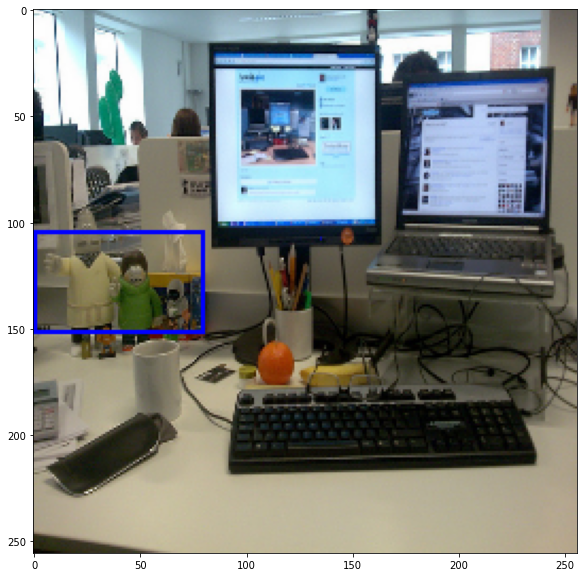

In [214]:
n=1570

encoded_left_text, images, encoded_right_text, _ = val_dataset.__getitem__(n)

text_prompt = 'найди на картинке все '
text = 'игрушки на столе'
encoded_left_text = val_dataset.encode_text(text=text_prompt+text,text_seq_length=args.l_text_seq_length, add_special = True)
encoded_left_text[torch.where(encoded_left_text == val_dataset.spc_id)] = val_dataset.spc_tokens['<LT_ODG>']

encoded_left_text = encoded_left_text.unsqueeze(0)
images = images.unsqueeze(0)
encoded_right_text = encoded_right_text.unsqueeze(0)

print(decode_text(tokenizer, encoded_left_text, ignore_ids))
    
bs_text = encoded_left_text.shape[0]

images = images.to(device)

image_seq_length = args.image_tokens_per_dim ** 2
total_seq_length = args.l_text_seq_length + image_seq_length + args.r_text_seq_length
encoded_images = vae.get_codebook_indices(images, disable_gumbel_softmax=True)

## Генерируем правые текстовые токены
pred_tokens, probs = api.generate_text_answers(encoded_images, encoded_left_text.type(torch.LongTensor), api.vocab_size, 
                            top_k=32, top_p=0.8, temperature=1.0, template = '', 
                            allowed_token_ids =allowed_token_ids, special_token='<RT_ODG>')
fake_cat_token = SPC_TOKENS['<RT_NL>']

target_fake_cat_token_idxs = torch.where(encoded_right_text[0,:]==fake_cat_token)[0]
if len(target_fake_cat_token_idxs)>0:
    target_end_idx = min(target_fake_cat_token_idxs)-4
else:
    target_end_idx=args.r_text_seq_length

if len(torch.where(pred_tokens[0,:]==fake_cat_token)[0])>0:
    pred_end_idx = min(torch.where(pred_tokens[0,:]==fake_cat_token)[0].cpu().numpy())-4
else:
    pred_end_idx=args.r_text_seq_length

target_len = (target_end_idx-2)//args.ob_seq_len
pred_len = (pred_end_idx-2)//args.ob_seq_len

pred =  decode_right_prob(pred_tokens[0,2:pred_end_idx], probs=probs, prob_threshold=0,
                           obj_det_seq_len=args.ob_seq_len, length=None, min_samples=1)

target = decode_right(encoded_right_text[0,2:target_end_idx], length=max(target_len,pred_len))

img = images.squeeze(0).cpu()

img *= 255
img = img.to(torch.uint8)

real_len = len(torch.where(target[0]['labels']!=1)[0])

pred_len = len(torch.where(pred[0]['labels']!=1)[0])
pred_colors = [(0,0,255)]*pred_len 
img_with_bboxes = draw_bounding_boxes(
    img, boxes=pred[0]["boxes"][:pred_len],colors=pred_colors, width=2)

img_with_bboxes = TF.to_pil_image(img_with_bboxes.detach())

plt.rcParams['figure.figsize'] = [10, 10]

plt.imshow(img_with_bboxes)


# метрики

In [ ]:
api = ruDolphPhraseGroundingApi(model, tokenizer, vae, spc_tokens=SPC_TOKENS)
pred_lens = []
tgt_lens = []
preds = []
tgts = []
gts = []
allowed_token_ids = list(SPC_TOKENS.values())+[0,3]

val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

for i,batch in enumerate(val_dataloader):
    encoded_left_text, images, encoded_right_text, ground_truth = batch
    
    bs_text = encoded_left_text.shape[0]

    images = images.to(device)

    image_seq_length = args.image_tokens_per_dim ** 2
    total_seq_length = args.l_text_seq_length + image_seq_length + args.r_text_seq_length
    encoded_images = vae.get_codebook_indices(images, disable_gumbel_softmax=True)

    ## Генерируем правые текстовые токены
    pred_tokens, probs = api.generate_text_answers(encoded_images, encoded_left_text.type(torch.LongTensor), api.vocab_size, 
                                top_k=32, top_p=0.8, temperature=1.0, template = '', 
                                allowed_token_ids =allowed_token_ids, special_token='<RT_ODG>')
    fake_cat_token = SPC_TOKENS['<RT_NL>']
    
    target_fake_cat_token_idxs = torch.where(encoded_right_text[0,:]==fake_cat_token)[0]
    if len(target_fake_cat_token_idxs)>0:
        target_end_idx = min(target_fake_cat_token_idxs)-4
    else:
        target_end_idx=args.r_text_seq_length
    
    if len(torch.where(pred_tokens[0,:]==fake_cat_token)[0])>0:
        pred_end_idx = min(torch.where(pred_tokens[0,:]==fake_cat_token)[0].cpu().numpy())-4
    else:
        pred_end_idx=args.r_text_seq_length
        
    cat_idxs = [1 + (k+1)*5 for k in range(args.r_text_seq_length//5)]
    min_cat_idxs = torch.where(pred_tokens[0,cat_idxs]<SPC_TOKENS['<RT_NB>'])[0]
    if len(min_cat_idxs)>0:
        pred_end_idx = min(cat_idxs[min(min_cat_idxs).int()], pred_end_idx)
    
        
    target_len = (target_end_idx-2)//args.ob_seq_len
    pred_len = (pred_end_idx-2)//args.ob_seq_len
    gt_len = len(ground_truth[0])//args.ob_seq_len
    
    gt = decode_ground_truth(ground_truth[0], length=gt_len)
    pred = decode_right_prob(pred_tokens[0,2:pred_end_idx], probs=probs, prob_threshold=args.prob_threshold,
                           obj_det_seq_len=args.ob_seq_len, length=None)
        
    target = decode_right(encoded_right_text[0,2:target_end_idx], length=target_len)
    
    preds.append(pred)
    tgts.append(target)
    gts.append(gt)

In [184]:
def bbox2coco(bbox):
    return [float(bbox[0]), float(bbox[1]), float(bbox[2]-bbox[0]), float(bbox[3]-bbox[1])]

def create_coco(samples):
    res_coco = {'info': {'description': 'rask',
      'url': 'http://none',
      'version': '1.0',
      'year': 2022,
      'contributor': 'rask',
      'date_created': '2022/12/26'},
     'licenses':[]}
    anns = []
    count = 0
    images = []
    for idx, sample in enumerate(samples):
        anns_from_sample = sample2ann_res(sample[0],idx)
        image = {'id':idx, 'file_name':'', 'height':256, 'width':256}
        images.append(image)
        for ann_s in anns_from_sample:
            ann = {}
            ann['id'] = count
            ann['image_id'] = ann_s["image_id"]
            ann['iscrowd'] = 0
            ann["category_id"] = ann_s["category_id"]
            ann['bbox'] = ann_s['bbox']
            ann['area'] = ann_s['bbox'][2]*ann_s['bbox'][3]
            x1, x2 = ann_s['bbox'][0], ann_s['bbox'][0]+ann_s['bbox'][2]
            y1, y2 = ann_s['bbox'][1], ann_s['bbox'][1]+ann_s['bbox'][3]
            ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
            anns.append(ann)
            count += 1
    res_coco['images'] = images
    res_coco['annotations'] = anns
    res_coco['categories'] = [{"id": 0, "name": "real object", "supercategory": "real object"},
                              {"id": 1, "name": "fake object", "supercategory": "fake object"}]
    return res_coco

def sample2ann_res(sample, image_id):
    fake_idxs = torch.where(sample['boxes']==0)[0]
    lst_idx = 1
    if len(fake_idxs)>0:
        lst_idx = min(fake_idxs)
    res = []
    for k in range(lst_idx):
        coco_sample = {}
        coco_sample['id'] = k
        if len(sample['boxes'])>0:
            coco_sample['bbox'] = bbox2coco(sample['boxes'][k,:])
            coco_sample['score'] = int(sample['scores'][k])*100
            coco_sample["category_id"] = int(sample['labels'][k])
            coco_sample["image_id"] = image_id
        else:
            coco_sample['bbox'] = [0,0,0,0]
            coco_sample['score'] = 1
            coco_sample["category_id"]  = 1
            coco_sample["image_id"] = image_id
        res.append(coco_sample)
    return res

def create_results(samples):
    results = []
    r_count = 0
    for idx, sample in enumerate(samples):
        res = sample2ann_res(sample[0], image_id=idx)
        for r in res:
            r['id'] = r_count
            results.append(r)
            r_count += 1
    return results

In [185]:
t_s =  create_coco(tgts)
g_s =  create_coco(gts)
p_s = create_results(preds)

json_object = json.dumps(p_s, indent=4)
with open(r"../../data/m_vg_coco_valid_predictions.json", "w") as outfile:
    outfile.write(json_object)
    
json_object = json.dumps(t_s, indent=4)
with open(r"../../data/m_vg_coco_valid_targets.json", "w") as outfile:
    outfile.write(json_object)
    
json_object = json.dumps(g_s, indent=4)
with open(r"../../data/m_vg_coco_valid_ground_truth.json", "w") as outfile:
    outfile.write(json_object)

In [186]:
cocoGt = COCO(r"../../data/m_vg_coco_valid_ground_truth.json")
cocoDt = cocoGt.loadRes(r"../../data/m_vg_coco_valid_predictions.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [187]:
cocoEval = COCOeval(cocoGt, cocoDt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).


In [188]:
cocoEval.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522
